In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

In [2]:
data = pd.read_excel('/Users/rachael/Downloads/train_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','stance']]
file['stance'].value_counts()
label_stance= file['stance'].value_counts()
label_proportions_stance= file['stance'].value_counts(normalize=True)
print("Counts of each label_stance:")
print(label_stance)
print("\nProportions of each label_stance:")
print(label_proportions_stance)

Counts of each label_stance:
stance
Aganist    186
Neither    140
Support     82
Name: count, dtype: int64

Proportions of each label_stance:
stance
Aganist    0.455882
Neither    0.343137
Support    0.200980
Name: proportion, dtype: float64


In [3]:
import re
def remove_urls(text):
    # 定义URL的正则表达式
    url_pattern = r'https?://\S+|www\.\S+'
    # 使用re.sub()函数替换URL为空字符串
    no_url_text = re.sub(url_pattern, '', text)
    return no_url_text

def clean_text(text):
    # Remove anything that is not a letter or space
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optional: Convert text to lower case
    clean_text = clean_text.lower()
    return clean_text

In [4]:
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
y = file['stance']
X = file['content']

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10127/271919431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(remove_urls)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10127/271919431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(clean_text)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10127/271919431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [5]:
import fasttext

# Path to your FastText pre-trained word embedding file
fasttext_model_path = '/Users/rachael/Downloads/cc.nl.300.bin'

# Load the FastText model
ft = fasttext.load_model(fasttext_model_path)

In [6]:
import spacy
nlp = spacy.load("nl_core_news_sm")
#tokenize
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

def sentence_to_avg_vec(tokens, model):
    vector_size = model.get_dimension()
    vec = np.zeros(vector_size)
    count = 0
    for token in tokens:
        vec += model.get_word_vector(token)
        count += 1
    if count != 0:
        vec /= count
    return vec

In [7]:
# Initialize parameters
best_score = 0
best_params = {}

#hyperparameter range
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'saga'],  # Solvers that support multinomial loss
    'max_iter': [20000, 30000,40000],  # Maximum number of iterations
}

test_scores = []
best_params_list = []
f1_scores = []

withouteda

In [13]:
# Stratified K-fold for maintaining label distribution, shuffle=True ensures different data splits in each iteration
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr = LogisticRegression(multi_class='multinomial', random_state=42,class_weight='balanced')
randomized_search = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1
    )

# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]

         # 进行tokenize
    X_train_tokenized = trainX.apply(tokenize)
    X_test_tokenized = testX.apply(tokenize)
    train_vectors = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_train_tokenized])
    test_vectors = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_test_tokenized])

    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    lr = LogisticRegression(multi_class='multinomial', random_state=42,class_weight='balanced')
    randomized_search = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1
    )

    # Fit Randomized Search
    randomized_search.fit(train_vectors, trainy)

   # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # Evaluate on the test set
    test_predictions = best_model.predict(test_vectors)
    test_score = f1_score(testy, test_predictions,average='macro')

    test_scores.append(test_score)
    best_params_list.append(best_params)

    print(f"Fold test score: {test_score}")
    print(f"Best parameters: {best_params}")

# Summarize the results
mean_test_score = np.mean(test_scores)
std_test_score = np.std(test_scores)

print(f"Mean test score: {mean_test_score}")
print(f"Standard deviation of test scores: {std_test_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold test score: 0.393509620417478
Best parameters: {'solver': 'newton-cg', 'max_iter': 40000, 'C': 0.23357214690901212}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold test score: 0.4670465337132004
Best parameters: {'solver': 'lbfgs', 'max_iter': 40000, 'C': 206.913808111479}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold test score: 0.44711120988020125
Best parameters: {'solver': 'newton-cg', 'max_iter': 40000, 'C': 0.23357214690901212}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold test score: 0.34987468671679195
Best parameters: {'solver': 'saga', 'max_iter': 20000, 'C': 10000.0}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold test score: 0.5541130604288499
Best parameters: {'solver': 'lbfgs', 'max_iter': 40000, 'C': 206.913808111479}
Mean test score: 0.44233102223130427
Standard deviation of test scores: 0.06936949476132445
Best paramete

In [8]:
params = {'solver': 'lbfgs', 'max_iter': 40000, 'C': 206.913808111479}



In [9]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_tokenized])

final_model = LogisticRegression(multi_class='multinomial', random_state=42,class_weight='balanced',**params)
final_model.fit(X_embeddings, y)

LogisticRegression(C=206.913808111479, class_weight='balanced', max_iter=40000,
                   multi_class='multinomial', random_state=42)

In [10]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#process test data 
test = test[['content','stance']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['stance'] = test['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in test_tokenized])
#predict 
test_predictions = final_model.predict(test_embedding)
conf_matrix = confusion_matrix(test['stance'], test_predictions)
class_report = classification_report(test['stance'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.31      0.43      0.36        76
           1       0.56      0.55      0.56       191
           2       0.60      0.49      0.54       140

    accuracy                           0.51       407
   macro avg       0.49      0.49      0.48       407
weighted avg       0.53      0.51      0.51       407



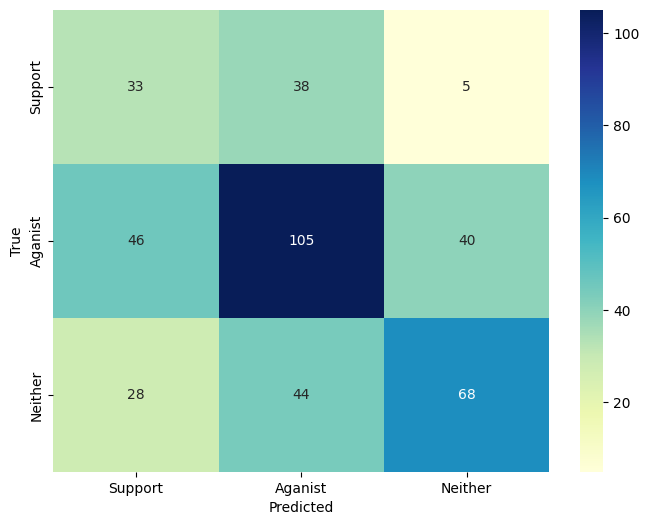

ValueError: DataFrame constructor not properly called!

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Support', 'Aganist', 'Neither'], yticklabels=['Support', 'Aganist', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 绘制分类报告热图
report_df = pd.DataFrame(class_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title('Classification Report Heatmap')
plt.show()

In [11]:
data = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','stance','sentiment']]
file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
stance_0_sentiment = file[file['sentiment'] == 0][['content','stance']]
stance_1_sentiment = file[file['sentiment'] == 1][['content','stance']]
stance_2_sentiment = file[file['sentiment'] == 2][['content','stance']] 

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10127/4231639426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10127/4231639426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10127/4231639426.py:6: Se

In [13]:
stance_0_tokenized = stance_0_sentiment['content'].apply(tokenize)
stance_0_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_0_tokenized])
stance_0_predictions = final_model.predict(stance_0_embedding )
stance_0_class_report = classification_report(stance_0_sentiment['stance'], stance_0_predictions)
print('stance_0_class_report:',stance_0_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.85      0.44      0.58        25
           1       0.06      0.20      0.09         5
           2       0.43      0.38      0.40         8

    accuracy                           0.39        38
   macro avg       0.44      0.34      0.36        38
weighted avg       0.65      0.39      0.48        38



In [14]:
stance_1_tokenized = stance_1_sentiment['content'].apply(tokenize)
stance_1_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_1_tokenized])
stance_1_predictions = final_model.predict(stance_1_embedding )
stance_1_class_report = classification_report(stance_1_sentiment['stance'], stance_1_predictions)
print('stance_0_class_report:',stance_1_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.25      0.47      0.33        38
           1       0.74      0.55      0.63       170
           2       0.28      0.35      0.31        37

    accuracy                           0.51       245
   macro avg       0.42      0.46      0.42       245
weighted avg       0.60      0.51      0.54       245



In [15]:
stance_2_tokenized = stance_2_sentiment['content'].apply(tokenize)
stance_2_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_2_tokenized])
stance_2_predictions = final_model.predict(stance_2_embedding )
stance_2_class_report = classification_report(stance_2_sentiment['stance'], stance_2_predictions)
print('stance_0_class_report:',stance_2_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.18      0.31      0.23        13
           1       0.24      0.62      0.34        16
           2       0.87      0.55      0.67        95

    accuracy                           0.53       124
   macro avg       0.43      0.49      0.41       124
weighted avg       0.71      0.53      0.58       124



witheda

In [17]:
# Stratified K-fold for maintaining label distribution, shuffle=True ensures different data splits in each iteration
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr = LogisticRegression(multi_class='multinomial', random_state=42)
randomized_search = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1
    )

# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]

    # 将 y_train 和 y_test 转换为 DataFrame
    y_train_df = pd.DataFrame(trainy).reset_index(drop=True)
    y_test_df = pd.DataFrame(testy).reset_index(drop=True)

    # 拼接 X_train 和 y_train 以及 X_test 和 y_test
    train_df = pd.concat([trainX.reset_index(drop=True), y_train_df], axis=1)
    test_df = pd.concat([testX.reset_index(drop=True), y_test_df], axis=1)

    # 标准化处理文本
    train_df['content'] = train_df['content'].apply(lambda x: ' '.join(x.split()))
    sentiment_0 = train_df[train_df['stance'] == 0]
    sentiment_1 = train_df[train_df['stance'] == 1]
    sentiment_2 = train_df[train_df['stance'] == 2]

    # 数据增强
    output_file_path0 = '/Users/rachael/Desktop/data/sentiment_0.txt'
    with open(output_file_path0, 'w', encoding='utf-8') as f:
        for _, row in sentiment_0.iterrows():
            f.write(f"{row['stance']}\t{row['content']}\n")

    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path0,
        '--output', '/Users/rachael/Desktop/data/augmented_train0.txt',
        '--num_aug', '6',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])

    output_file_path1 = '/Users/rachael/Desktop/data/sentiment_1.txt'
    with open(output_file_path1, 'w', encoding='utf-8') as f:
        for _, row in sentiment_1.iterrows():
            f.write(f"{row['stance']}\t{row['content']}\n")

    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path1,
        '--output', '/Users/rachael/Desktop/data/augmented_train1.txt',
        '--num_aug', '2',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])

    output_file_path2 = '/Users/rachael/Desktop/data/sentiment_2.txt'
    with open(output_file_path2, 'w', encoding='utf-8') as f:
        for _, row in sentiment_2.iterrows():
            f.write(f"{row['stance']}\t{row['content']}\n")

    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path2,
        '--output', '/Users/rachael/Desktop/data/augmented_train2.txt',
        '--num_aug', '3',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])

    # Load augmented data
    file4 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train0.txt', delimiter='\t', header=None, names=['stance', 'content'])
    file5 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train1.txt', delimiter='\t', header=None, names=['stance', 'content'])
    file6 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train2.txt', delimiter='\t', header=None, names=['stance', 'content'])
    augmented_train = pd.concat([file4, file5, file6])

    #process train data
    augmented_train['content'] = augmented_train['content'].astype(str)
    train_sentences = [item for item in list(augmented_train['content'])]
    train_labels = [int(item) for item in list(augmented_train['stance'])]
    X_train_tokenized = [tokenize(sentence) for sentence in train_sentences]
    train_vectors = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_train_tokenized])

    test_df['content'] = test_df['content'].astype(str)
    test_sentences = [item for item in list(test_df['content'])]
    test_labels = [int(item) for item in list(test_df['stance'])]
    X_test_tokenized = [tokenize(sentence) for sentence in test_sentences]
    test_vectors = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_test_tokenized])

    # Fit Randomized Search
    randomized_search.fit(train_vectors, train_labels)

    # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # Evaluate on the test set
    test_predictions = best_model.predict(test_vectors)
    test_f1_score = f1_score(test_labels, test_predictions,average ='macro')

    f1_scores.append(test_f1_score)
    best_params_list.append(best_params)

    print(f"Fold F1-score: {test_f1_score}")
    print(f"Best parameters: {best_params}")

# Summarize the results
mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

print(f"Mean F1-score: {mean_f1_score}")
print(f"Standard deviation of F1-scores: {std_f1_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=6
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=2
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_2.txt to /Users/rachael/Desktop/data/augmented_train2.txt with num_aug=3
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold F1-score: 0.37447750644779276
Best parameters: {'solver': 'lbfgs', 'max_iter': 20000, 'C': 10000.0}
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=6
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=2
generated augmented sentences with eda for /Users/rachael/Desk

In [18]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'C': 10000.0, 'max_iter': 20000, 'solver': 'lbfgs'}


In [13]:
most_common_params = {'solver': 'lbfgs', 'max_iter': 20000, 'C': 10000.0}


In [14]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_tokenized])

final_model = LogisticRegression(multi_class='multinomial', random_state=42, **most_common_params,class_weight='balanced')
final_model.fit(X_embeddings, y)

LogisticRegression(C=10000.0, class_weight='balanced', max_iter=20000,
                   multi_class='multinomial', random_state=42)

In [15]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#process test data 
test = test[['content','stance']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['stance'] = test['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in test_tokenized])
#predict 
test_predictions = final_model.predict(test_embedding)
conf_matrix = confusion_matrix(test['stance'], test_predictions)
class_report = classification_report(test['stance'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.32      0.38      0.35        76
           1       0.56      0.57      0.56       191
           2       0.55      0.47      0.51       140

    accuracy                           0.50       407
   macro avg       0.47      0.47      0.47       407
weighted avg       0.51      0.50      0.50       407



In [21]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'C': 10000.0, 'max_iter': 20000, 'solver': 'lbfgs'}


In [22]:
most_common_params =  {'C': 10000.0, 'max_iter': 20000, 'solver': 'lbfgs'}

In [23]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(sentence,ft) for sentence in X_tokenized])

final_model1 = LogisticRegression(multi_class='multinomial', random_state=42, **most_common_params,class_weight='balanced')
final_model1.fit(X_embeddings, y)

LogisticRegression(C=10000.0, class_weight='balanced', max_iter=20000,
                   multi_class='multinomial', random_state=42)

In [25]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#process test data 
test = test[['content','stance']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['stance'] = test['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in test_tokenized])
#predict 
test_predictions = final_model1.predict(test_embedding)
conf_matrix = confusion_matrix(test['stance'], test_predictions)
class_report = classification_report(test['stance'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.32      0.38      0.35        76
           1       0.56      0.57      0.56       191
           2       0.55      0.47      0.51       140

    accuracy                           0.50       407
   macro avg       0.47      0.47      0.47       407
weighted avg       0.51      0.50      0.50       407



In [26]:
data = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','stance','sentiment']]
file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
stance_0_sentiment = file[file['stance'] == 0][['content','sentiment']]
stance_1_sentiment = file[file['stance'] == 1][['content','sentiment']]
stance_2_sentiment = file[file['stance'] == 2][['content','sentiment']] 

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_3580/2001043649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_3580/2001043649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_3580/2001043649.py:6: Setti

In [28]:
stance_0_tokenized = stance_0_sentiment['content'].apply(tokenize)
stance_0_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_0_tokenized])
stance_0_predictions = final_model1.predict(stance_0_embedding )
stance_0_class_report = classification_report(stance_0_sentiment['sentiment'], stance_0_predictions)
print('stance_0_class_report:',stance_0_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.41      0.48      0.44        25
           1       0.57      0.53      0.55        38
           2       0.25      0.23      0.24        13

    accuracy                           0.46        76
   macro avg       0.41      0.41      0.41        76
weighted avg       0.46      0.46      0.46        76



In [31]:
stance_1_tokenized = stance_1_sentiment['content'].apply(tokenize)
stance_1_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_1_tokenized])
stance_1_predictions = final_model1.predict(stance_1_embedding )
stance_1_class_report = classification_report(stance_1_sentiment['sentiment'], stance_1_predictions)
print('stance_0_class_report:',stance_1_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.03      0.20      0.04         5
           1       0.90      0.58      0.70       170
           2       0.14      0.38      0.21        16

    accuracy                           0.55       191
   macro avg       0.36      0.38      0.32       191
weighted avg       0.81      0.55      0.64       191



In [32]:
stance_2_tokenized = stance_2_sentiment['content'].apply(tokenize)
stance_2_embedding = np.array([sentence_to_avg_vec(sentence,ft) for sentence in stance_2_tokenized])
stance_2_predictions = final_model1.predict(stance_2_embedding )
stance_2_class_report = classification_report(stance_2_sentiment['sentiment'], stance_2_predictions)
print('stance_0_class_report:',stance_2_class_report)

stance_0_class_report:               precision    recall  f1-score   support

           0       0.04      0.12      0.06         8
           1       0.37      0.51      0.43        37
           2       0.76      0.53      0.62        95

    accuracy                           0.50       140
   macro avg       0.39      0.39      0.37       140
weighted avg       0.62      0.50      0.54       140

